In [40]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
from scipy import stats

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 10

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster

from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import  KNeighborsRegressor
from sklearn import linear_model
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg

from skforecast.utils import load_forecaster

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from keras import optimizers,callbacks
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Input

# Calculo de metricas
# ==============================================================================
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error
from sklearn import metrics

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'
# warnings.filterwarnings('ignore')

In [2]:
# Common code for display result
def show_graph(df1,df2,title):
    data = pd.concat([df1, df2])
    data.reset_index(inplace=True, drop=True)
    for col in data.columns:
        if col.lower().startswith('pred'):
            data[col].plot(label=col,linestyle="dotted")
        else:
            data[col].plot(label=col)
    plt.title(title)
    plt.legend()
    plt.show()

In [3]:
def evaluacion_metrica(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2: {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [4]:
# Carga de datos
# ==============================================================================
folder = "C:\\Users\\Martinejo\\Documents\\UMH\\INVESTIGACION\\MARGARITA_SALAS\\Sistema_Riego\\"
parametro = 'eto'
output=parametro
inputs_sen = [
          'fecha', 'eto','viento_med','precip','temp_med','hr_med','rad_med'
          ]
inputs_sat = [
          'date', 'ndvi_mean','ndwi_mean','ndmi_mean','gndvi_mean','evi_mean','evi2_mean','savi_mean'
          ]
usecols_sen = inputs_sen.copy()
usecols_sat = inputs_sat.copy()

datos_sen = pd.read_csv(folder + "agroclimatology_parcel_1_ORIGINAL" + ".csv",sep=',', usecols=usecols_sen)
datos_sat = pd.read_csv(folder + "teledeteccion_sentinel2_parcel_1" + ".csv",sep=',', usecols=usecols_sat)

datos_sen = datos_sen.drop_duplicates()
datos_sat = datos_sat.drop_duplicates()

In [5]:
datos = datos_sen.copy()

In [6]:
datos["eto"].isna().sum()

0

In [7]:
while datos["eto"].isna().sum() > 0:
    datos = datos.fillna(value=datos.shift(1))
    datos["eto"].isna().sum()

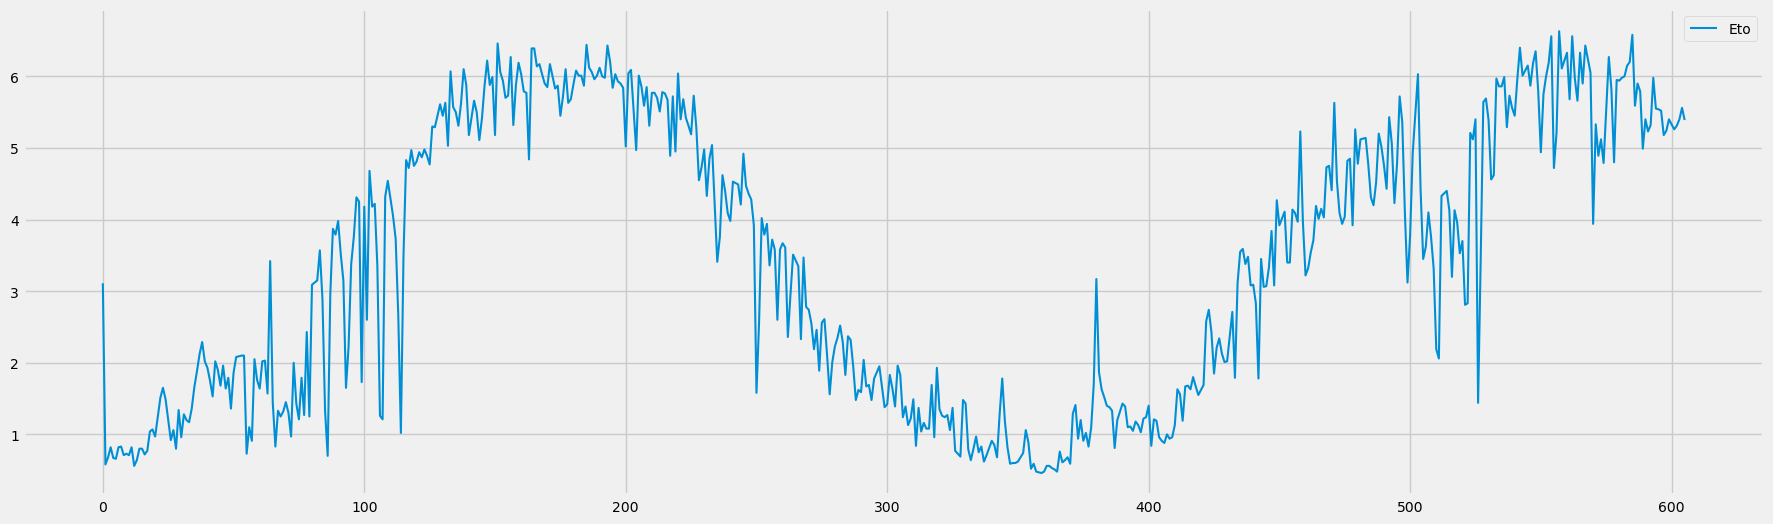

In [8]:
fig, ax = plt.subplots(figsize=(20, 6))
datos['eto'].plot(ax=ax, label='Eto')
#datos['ambiente'].plot(ax=ax, label='Ambiente')
#datos['nivel'].plot(ax=ax, label='Nivel')
ax.legend();

#COMENTAR ESTA LISTA PARA HACER EL ANÁLISIS CON LA PROPIA SERIE, Y NO CON LAS DIFERENCIAS
#datos = datos.diff().dropna()

## MODELADO

In [9]:
datos = datos.drop(columns=["fecha"])

In [10]:
def rmsle_cv(model,x,y):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(x.values)
    rmse= cross_val_score(model, x.values, y, scoring=None, cv = kf)
    return(rmse)

[0.86680979 0.81870273 0.69138684 0.9502081  0.95005131]


C:\Users\Martinejo\AppData\Local\Temp\ipykernel_24072\2519196872.py:13: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  l = plt.plot(lm.predict(datos_train), 'o', color='blue', label="Estimado", marker='x')


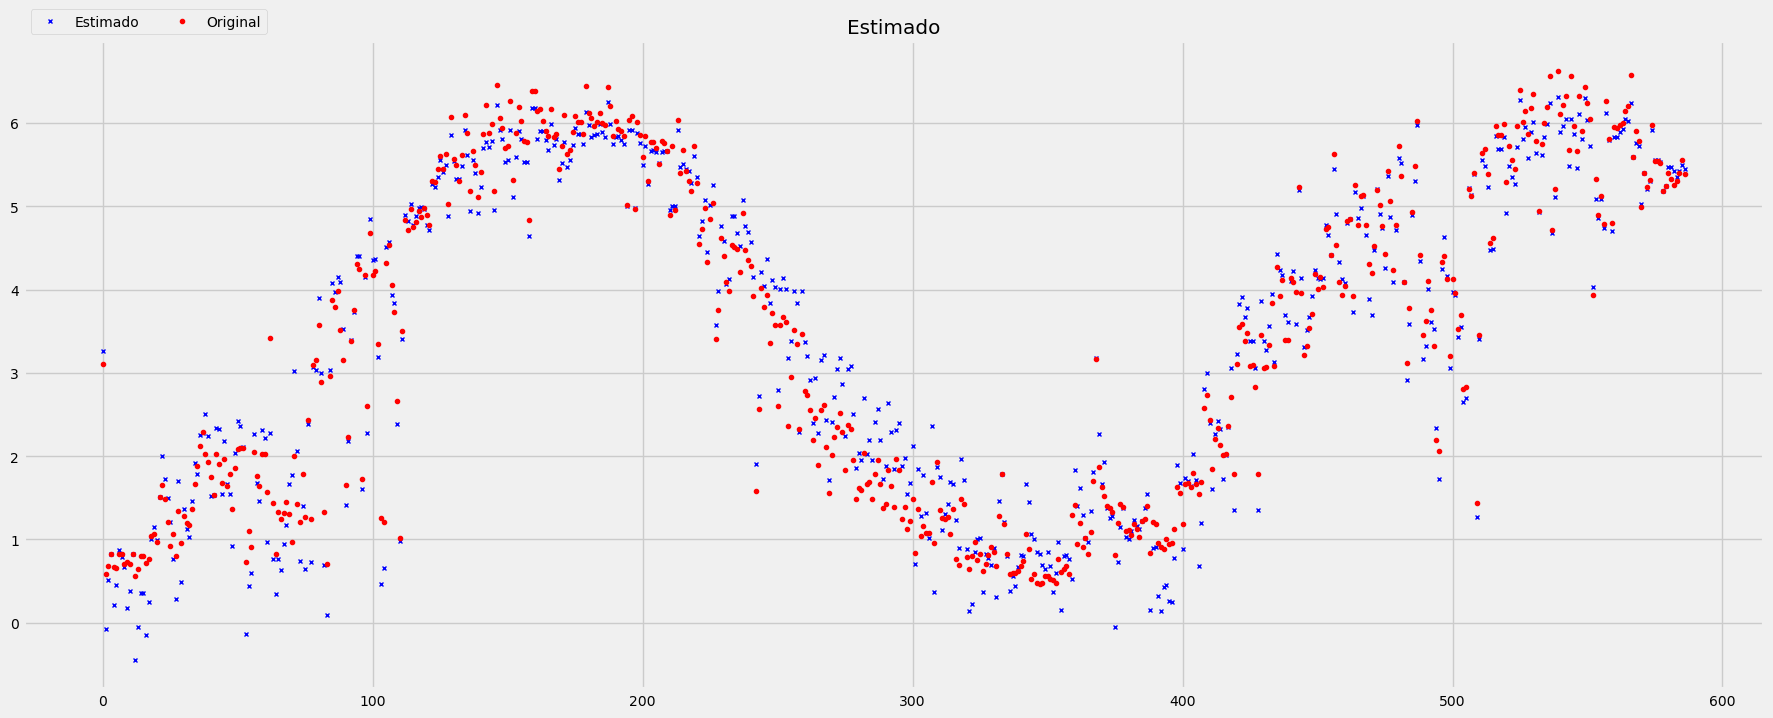

MAE = 0.174615


C:\Users\Martinejo\AppData\Local\Temp\ipykernel_24072\2519196872.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot(errores_Lineal, 'r--', color='green')


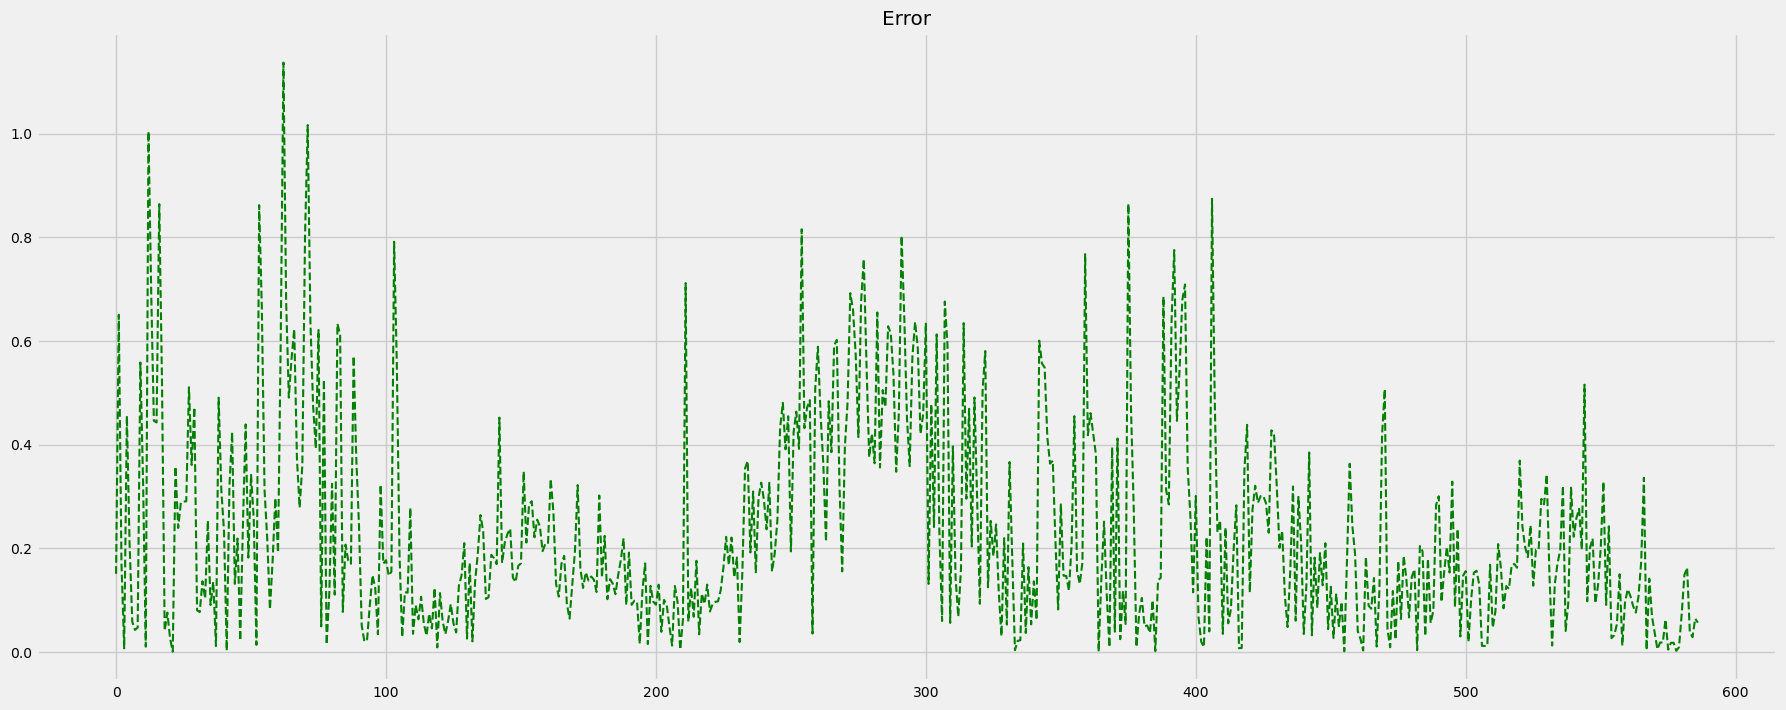

Lasso metrics: MAE = 0.2344 R2 = (0.9752)

[0.83761464 0.00999522 0.10597587 0.0058991  0.01281412]


In [11]:
y_train = datos["eto"].loc[:].values
datos_train = datos.drop(columns=['eto'])

lm = linear_model.LinearRegression()
model = lm.fit(datos_train,y_train)

res_lineal = rmsle_cv(lm,datos_train,y_train)
print(res_lineal)

plt.figure(figsize=(20,8))

#plt.title('Y_predict')
l = plt.plot(lm.predict(datos_train), 'o', color='blue', label="Estimado", marker='x')
plt.setp(l, markersize=3)

plt.title('Estimado')
q = plt.plot(y_train, 'o', color='red', label="Original")
plt.setp(q, markersize=3)
category_names = ['Estimado', 'Original']
legend = plt.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='medium')
plt.show()

MAE_lineal = median_absolute_error(y_train, lm.predict(datos_train))
print("MAE = %f" % MAE_lineal)

errores_Lineal = abs(y_train-lm.predict(datos_train))

plt.figure(figsize=(20,8))
plt.title('Error')
plt.plot(errores_Lineal, 'r--', color='green')
plt.show()

print("Lasso metrics: MAE = {:.4f} R2 = ({:.4f})\n".format(np.mean(errores_Lineal), r2_score(y_train, lm.predict(datos_train))))

print(lm.coef_)

##EL MODELO ES MUY BUENO POR T-1, SI QUITAMOS ESTA VARIABLE EMPEORA A 0.3 APROX

In [12]:
import statsmodels.api as sm
data_train = sm.add_constant(datos_train)
est = sm.OLS(y_train, data_train)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     4561.
Date:                Wed, 25 Oct 2023   Prob (F-statistic):               0.00
Time:                        08:35:44   Log-Likelihood:                -141.83
No. Observations:                 587   AIC:                             295.7
Df Residuals:                     581   BIC:                             321.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3634      0.108    -21.805      0.0

<Axes: >

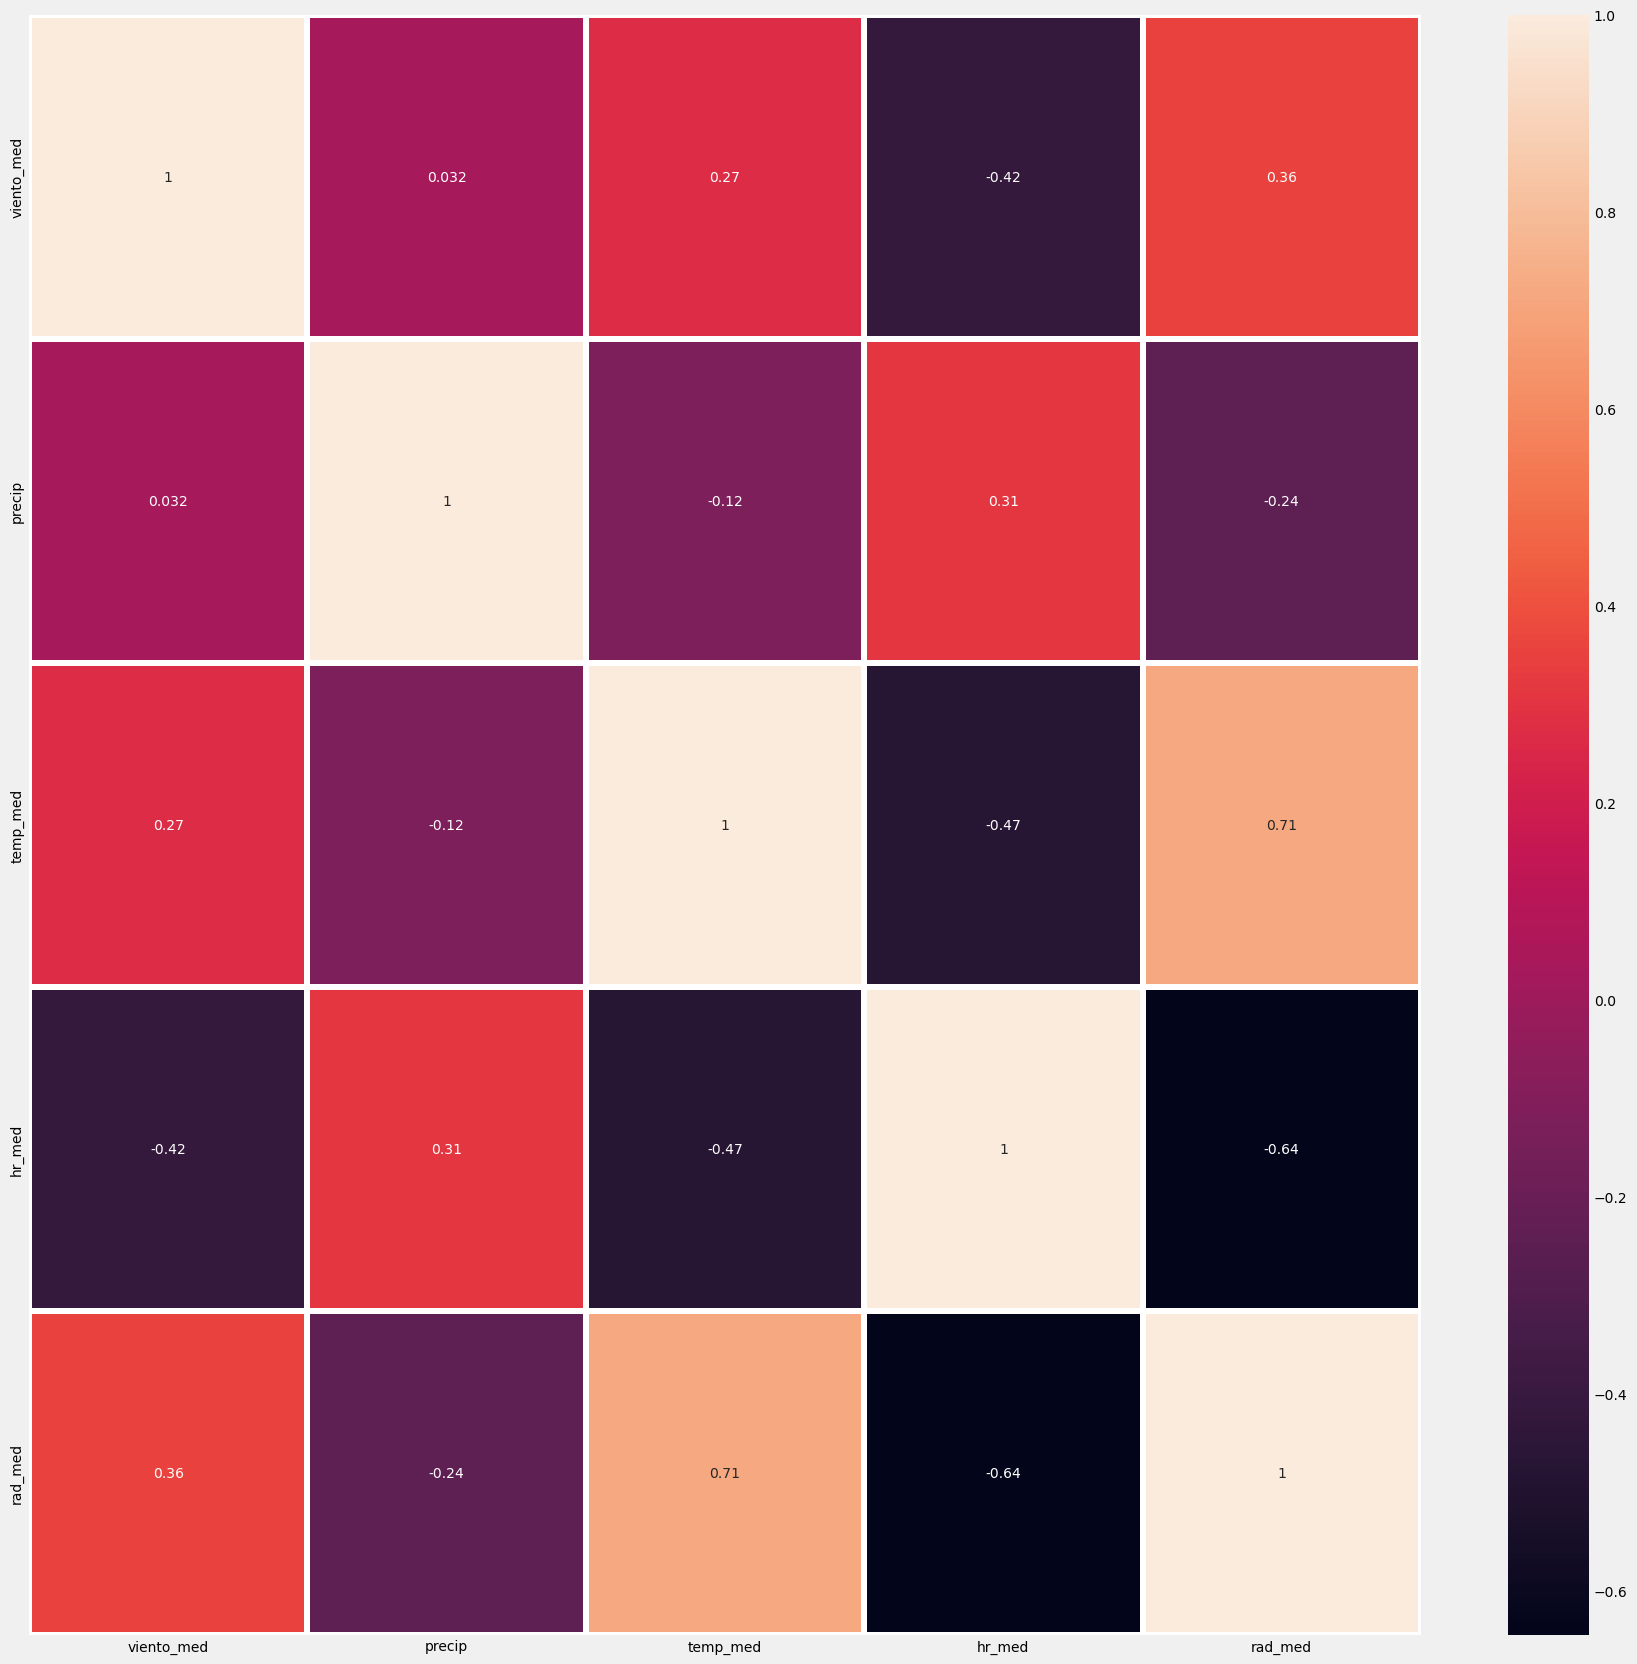

In [13]:
import seaborn as sns

correlation_mat = datos_train.corr()

fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(correlation_mat, annot=True, linewidths=3, ax=ax)

In [14]:
def ML_algorithms(algo):
    if algo == 'KNN':
      model = KNeighborsRegressor(5, weights='distance') # RDregresor
      return model

    if algo=="MLP":
      #(64, 32)	0.01	200.0
      model = MLPRegressor(hidden_layer_sizes=(32,32), learning_rate_init=0.01, max_iter=400, random_state=1)
      return model

    if algo=='DT':
      model = DecisionTreeRegressor(max_depth=8, min_samples_split=16,random_state=0)
      return model

    if algo=="RFR":
      #antes 16 y 4
      model =  RandomForestRegressor(random_state=0, n_estimators=8, min_samples_split=16)
      return model
  
    if algo=="LR":
        #antes 16 y 4
        model =  linear_model.LinearRegression()
        return model

In [41]:
algoritmos = ['KNN', 'MLP', 'DT', 'RFR','LR']
cv_scores = pd.DataFrame()
dfe=datos


inputs_sen = [
          'viento_med','precip','temp_med','hr_med','rad_med'
          ]

inputs_sat = [
          'ndvi_mean','ndwi_mean','ndmi_mean','gndvi_mean','evi_mean','evi2_mean','savi_mean'
          ]

for algo in algoritmos:

    print("Algoritmo", algo)
    dfwork = dfe

    x = dfwork[inputs_sen].values
    y = dfwork[output].values
    
    lm = ML_algorithms(algo)
      #model = lm.fit(x,y)
    kf = KFold(5, shuffle=True, random_state=42)
    icv=0
    acc_score = []
    for train, test in kf.split(x):
      X_train, X_test, y_train, y_test = x[train], x[test], y[train], y[test]
      model = lm.fit(X_train,y_train)
      ypred = model.predict(X_test)

      r2 = r2_score(y_test, ypred)
      mae = mean_absolute_error(y_test, ypred)
      mse = mean_squared_error(y_test, ypred)
      icv = icv + 1

      result = {"Algoritmh": algo, "cv":icv, "r2" : r2, 'MAE':mae, "MSE": mse}
      cv_scores = cv_scores.append(result, ignore_index=True)

r = cv_scores.groupby(['Algoritmh']).mean()
print(r)

Algoritmo KNN
Algoritmo MLP
Algoritmo DT
Algoritmo RFR
Algoritmo LR
            cv        r2       MAE       MSE
Algoritmh                                   
DT         3.0  0.962223  0.279950  0.143668
KNN        3.0  0.953808  0.309928  0.174506
LR         3.0  0.974219  0.237136  0.097587
MLP        3.0  0.959199  0.302567  0.154454
RFR        3.0  0.971345  0.245640  0.108658


In [43]:
entreno = 15

datos_entreno = datos.iloc[:-entreno] # PARA TENER UNA COPIA DEL ORIGINAL Y MODIFICAR LA COPIA

X_train = datos[inputs_sen].iloc[:-entreno]
y_train = datos[output].iloc[:-entreno]
X_test = datos[inputs_sen].iloc[-entreno:]
y_test = datos[output].iloc[-entreno:]

In [44]:
X_train.tail()

,viento_med,precip,temp_med,hr_med,rad_med
586,1.36,0.0,27.69,46.83,281.49
587,0.90,0.0,27.02,43.36,331.58
588,0.75,0.0,28.16,47.13,327.35
589,1.01,0.0,27.40,59.36,256.72
590,0.92,0.0,27.57,56.28,291.38


In [45]:
y_train.tail()

586    5.59
587    5.90
588    5.79
589    4.99
590    5.40
Name: eto, dtype: float64

In [46]:
X_train.describe()

,viento_med,precip,temp_med,hr_med,rad_med
count,572.000000,572.000000,572.000000,572.000000,572.000000
mean,0.691469,0.925699,19.502343,55.639930,214.202762
std,0.357322,4.443514,7.053781,14.087173,98.198756
min,0.000000,0.000000,5.700000,20.620000,18.920000
25%,0.460000,0.000000,13.450000,45.325000,127.202500
50%,0.680000,0.000000,19.395000,55.085000,225.505000
75%,0.860000,0.000000,26.262500,66.315000,306.582500
max,2.940000,57.400000,33.580000,89.080000,369.440000


In [47]:
y_train.describe()

count    572.000000
mean       3.365594
std        1.954341
min        0.460000
25%        1.430000
50%        3.435000
75%        5.292500
max        6.630000
Name: eto, dtype: float64

In [48]:
#model_LR =  linear_model.LinearRegression().fit(X_train,y_train)
model_LR = KNeighborsRegressor(5, weights='distance').fit(X_train,y_train)

ypred = model_LR.predict(X_test)

predicciones = pd.DataFrame() #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO
predicciones_fecha = pd.DataFrame() #ESTO PARA CREAR UN DATAFRAME SOLO CON LAS PREDICCIONES, PARA PINTAR LUEGO

predicciones["pred"] = ypred

r2 = r2_score(y_test, ypred)
mae = mean_absolute_error(y_test, ypred)
mse = mean_squared_error(y_test, ypred)

predicciones_fecha = X_test.copy()
predicciones_fecha["eto"] = predicciones["pred"].values

print(predicciones_fecha)

     viento_med  precip  temp_med  hr_med  rad_med       eto
591        0.59     0.0     29.41   52.38   285.25  5.653128
592        0.51     0.0     32.40   45.01   276.18  5.011291
593        1.09     0.0     30.13   56.34   299.87  5.765605
594        0.82     0.0     28.72   56.18   300.91  5.771739
595        0.88     0.0     27.85   57.29   303.92  5.889059
596        0.80     0.0     28.29   58.48   303.41  5.891603
597        0.81     0.0     28.58   57.88   272.88  5.393647
598        0.79     0.0     29.18   56.73   275.00  5.327171
599        0.65     0.0     29.77   56.34   296.94  5.623201
600        0.58     0.0     30.70   48.47   297.82  5.521744
601        0.60     0.0     30.51   43.27   296.14  5.456329
602        0.67     0.0     29.88   50.89   287.53  5.625430
603        0.71     0.0     29.92   45.80   293.12  5.638678
604        0.86     0.0     29.63   43.14   292.20  5.416589
605        0.74     0.0     29.85   41.68   295.05  5.310761


Evaluation metric results:-
MSE: 0.0660723694996396
MAE: 0.238498878909255
RMSE: 0.2570454619316194
MAPE: 4.41115839998755
R2: -0.7775406099694986



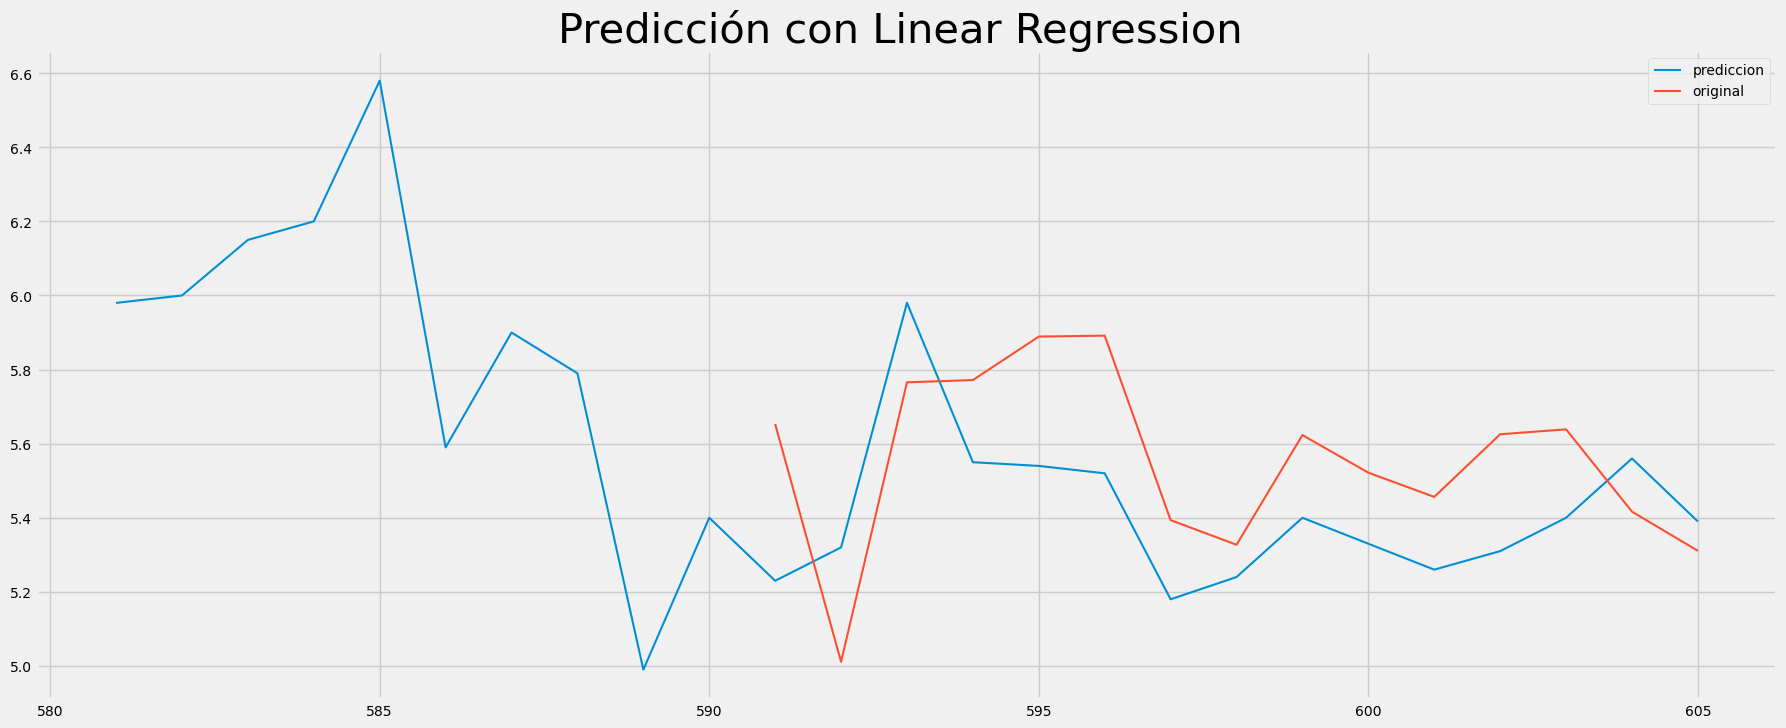

In [49]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.title("Predicción con Linear Regression ", fontsize=30);
#df_train['temperatura'].plot(ax=ax, label='train')
datos["eto"].tail(10+entreno).plot(ax=ax, label='prediccion')
predicciones_fecha["eto"].plot(ax=ax, label='original')
ax.legend();

evaluacion_metrica(y_true = y_test,y_pred = predicciones_fecha["eto"])
